# 1. Data Import and Initial Validation

- Import the data from its source into a Pandas DataFrame
- check for keys of the data and make sure it is alright
- Data type conversion
- Handling missing values of columns if there is any
- Check for duplicated rows in the data
- Check for duplicated `id` in the data. Is id for each song is unique?


In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('data/raw/rolling_stones_spotify.csv')
#checking keys of the data
# Clean all column names: remove spaces, special characters, lowercase
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True).str.lower()
print(df.keys())
#convert object columns 
df["release_date"] = pd.to_datetime(df["release_date"], format = "%m/%d/%Y", errors = "coerce")
df['name'] = df['name'].astype('string')
df['album'] = df['album'].astype('string')
df['id'] = df['id'].astype('string')
df['uri'] = df['uri'].astype('string')
print(df.info())
duplicate_rows_num = df.duplicated().sum()
missing_num = df.isnull().sum()
print('****************************************************************')
print(f"Number of duplicated rows in the data is : {duplicate_rows_num}")
print('****************************************************************')
print(f"Number of missing values in the data is : ")
print(f"{missing_num}")
print('****************************************************************')
print(f"Number of duplicated **id** in the data is : {duplicate_rows_num}")
print('****************************************************************')


Index(['number_row', 'name', 'album', 'release_date', 'track_number', 'id',
       'uri', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity',
       'duration_ms'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   number_row        1610 non-null   int64         
 1   name              1610 non-null   string        
 2   album             1610 non-null   string        
 3   release_date      1610 non-null   datetime64[ns]
 4   track_number      1610 non-null   int64         
 5   id                1610 non-null   string        
 6   uri               1610 non-null   string        
 7   acousticness      1610 non-null   float64       
 8   danceability      1610 non-null   float64       
 9   energy           

**Result of above cell:**
- No duplicated rows found in the data
- No null values found in the data
- All id are unique for each song
- Five columns with obj data type found: one converted to datetime type and rest to string


# 2. Check possible outliers using Interquartile Range (IQR) method

In [210]:
# Possible outliers using IQR for all numerical variables
print('Possible outliers:')
for i in range(7,18): 
    per_25=np.percentile(df.iloc[:,i],25)
    per_75=np.percentile(df.iloc[:,i],75)
    IQR=per_75-per_25
    higher_limit=per_75+1.5*IQR
    lower_limit=per_25-1.5*IQR
    outlier=df.iloc[:,i][(df.iloc[:,i]>=higher_limit)|(df.iloc[:,i]<=lower_limit)] 
    print(f'Number of outlier for {df.columns[i]}: {outlier.size}')

Possible outliers:
Number of outlier for acousticness: 4
Number of outlier for danceability: 0
Number of outlier for energy: 8
Number of outlier for instrumentalness: 272
Number of outlier for liveness: 0
Number of outlier for loudness: 14
Number of outlier for speechiness: 92
Number of outlier for tempo: 34
Number of outlier for valence: 0
Number of outlier for popularity: 50
Number of outlier for duration_ms: 76


# 2. Check for outliers using histogram plot and box plot
- To find posible outliers, I plotted histogram and box plots for each numerical variables
- Based on the plots, possible outliers are detected.

Number of numeric columns: 13
Numeric columns: ['number_row', 'track_number', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'duration_ms']


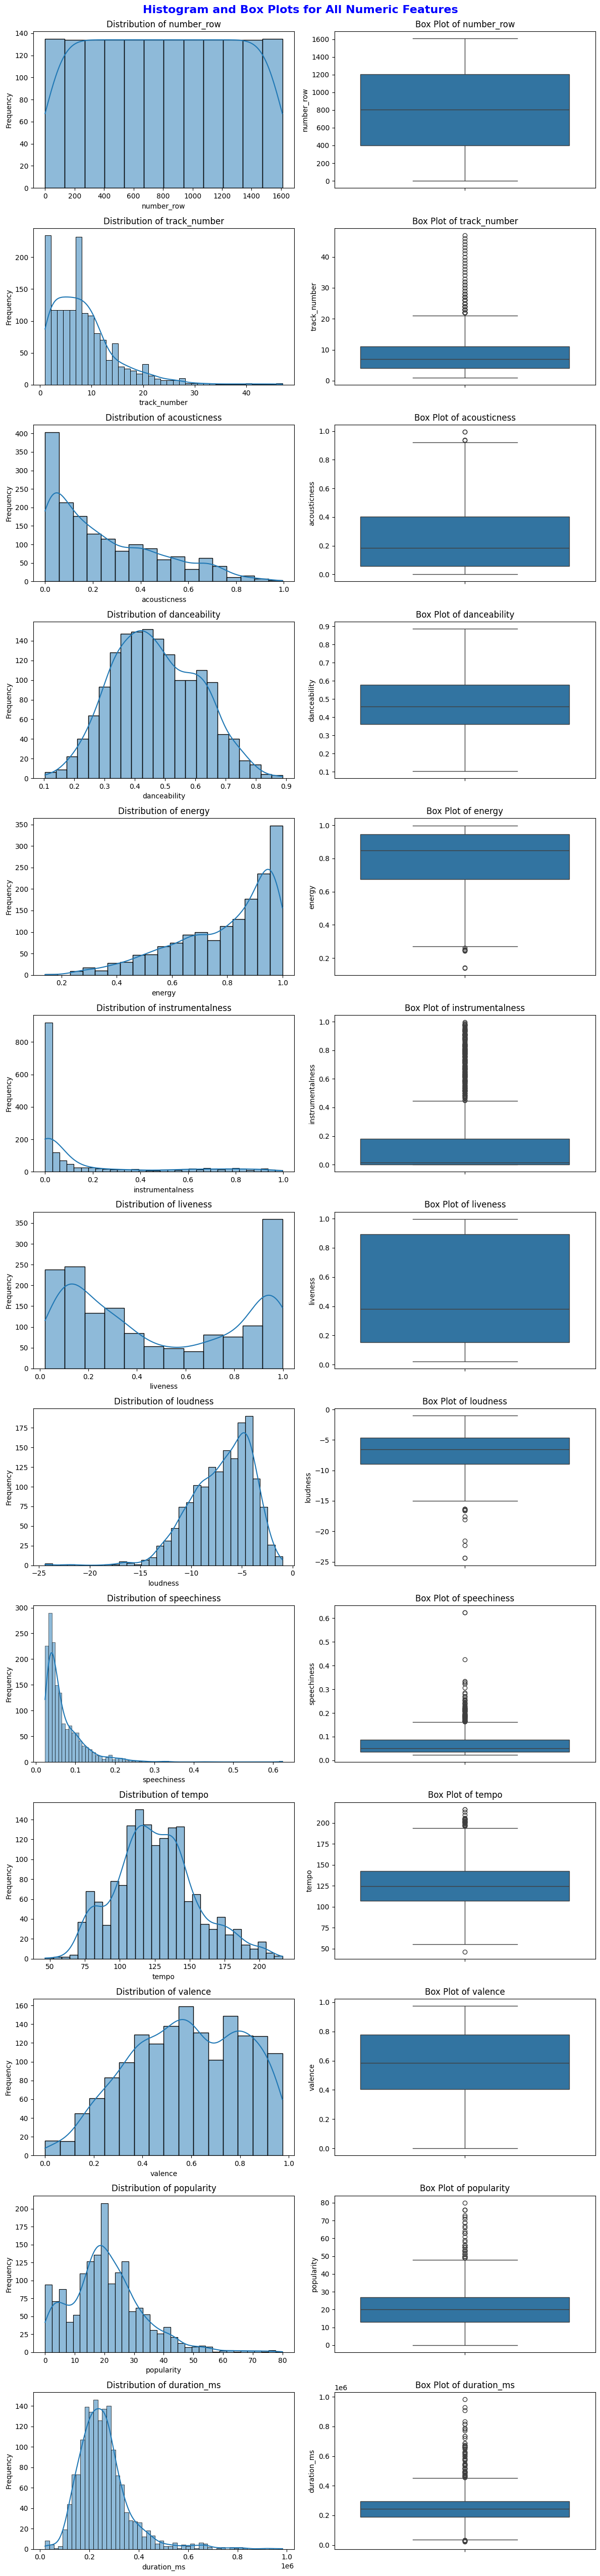

In [211]:
#plot histogram and box plots of numerical variables 

# Get numeric columns only (excluding non-numeric columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Number of numeric columns: {len(numeric_columns)}")
print(f"Numeric columns: {numeric_columns}")

# Create subplots - 2 columns for each numeric column (histogram + boxplot)
fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(12, 4 * len(numeric_columns)))

# If only one numeric column, axes becomes 1D, so we need to handle it
if len(numeric_columns) == 1:
    axes = axes.reshape(1, -1)  # Convert to 2D array

fig.suptitle('Histogram and Box Plots for All Numeric Features', fontsize=16, color='blue', fontweight='bold')

for i, col in enumerate(numeric_columns):
    # Histogram with KDE
    sns.histplot(data=df, x=col, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {col}', fontsize=12)
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')
    
    # Box plot
    sns.boxplot(y=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {col}', fontsize=12)
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.subplots_adjust(top=0.97)  # Adjust for suptitle
plt.savefig('plots/Histogram_Box_Plots.png')
plt.show()


**Result of above cell:** According to above results (IQR, Histogram and Box plot), significant outliers need to be removed from below variables: 
- acousticness
- eneregy
- loudness
- speechiness
- popularity
- duration_ms

# Sorting dataset based on each variable to learn more about outliers (top or bottom 10 data points shown using above plots)

In [212]:
#Check possible outlier based on values of acousticness
df_sorted_acousticness = df.sort_values(by='acousticness', ascending=False)
print('Sorted values of acousticness:')
print(df_sorted_acousticness['acousticness'].head(10))
#check for possible outliers based on values of energy
df_sorted_energy = df.sort_values(by='energy')
print('Sorted values of energy:')
print(df_sorted_energy['energy'].head(10))
#check for possible outliers based on values of loudness
df_sorted_loudness = df.sort_values(by='loudness')
print('Sorted values of loudness:')
print(df_sorted_loudness['loudness'].head(10))
#check for possible outliers based on values of speechiness
df_sorted_speechiness = df.sort_values(by='speechiness', ascending=False)
print('Sorted values of speechiness:')
print(df_sorted_speechiness['speechiness'].head(10))
#check for possible outliers based on values of popularity
df_sorted_popularity = df.sort_values(by='popularity', ascending=False)
print('Sorted values of popularity:')
print(df_sorted_popularity['popularity'].head(10))
#check for possible outliers based on values of duration_ms
df_sorted_duration_ms = df.sort_values(by='duration_ms', ascending=False)
print('Sorted values of duration_ms:')
print(df_sorted_duration_ms['duration_ms'].head(10))


Sorted values of acousticness:
807    0.994
818    0.994
997    0.939
165    0.935
280    0.920
308    0.920
113    0.914
255    0.900
81     0.898
989    0.892
Name: acousticness, dtype: float64
Sorted values of energy:
807     0.141
818     0.142
1333    0.242
1313    0.246
1325    0.248
1369    0.250
1118    0.252
1115    0.261
1186    0.272
1268    0.274
Name: energy, dtype: float64
Sorted values of loudness:
818    -24.408
807    -24.351
739    -22.301
1118   -21.548
546    -18.104
756    -17.577
1186   -16.572
300    -16.556
328    -16.556
1310   -16.415
Name: loudness, dtype: float64
Sorted values of speechiness:
308     0.624
280     0.624
81      0.425
553     0.335
558     0.330
312     0.323
284     0.323
213     0.306
1176    0.286
217     0.280
Name: speechiness, dtype: float64
Sorted values of popularity:
1403    80
1472    76
862     76
1248    76
1257    73
901     72
1023    71
893     69
1122    69
1256    67
Name: popularity, dtype: int64
Sorted values of duration_ms

**significant outlier removal from variables:**
- acousticness: first and second top data points (2 points)
- energy: first and second top data points (2 points)
- loudness: four top data points (4 points)
- speechiness: three top data points (3 points)
- popularity: first top data point (1 point)
- duration_ms: first three top data point (3 points)

# 3. Drop significant outliers from the dataset (listed above)
- Significant outliers are removed from the dataset by analzying sorted datapoint listed for each varaible (above cell) and the histogram and box plot
- Rest are kept for further investigation


In [213]:
# concatenate data points listed above
df_removed_items = pd.concat([df_sorted_acousticness.iloc[0:2,:], df_sorted_energy.iloc[0:2,:], df_sorted_loudness.iloc[0:4,:], df_sorted_speechiness.iloc[0:3,:], df_sorted_popularity.iloc[0:0,:], df_sorted_duration_ms.iloc[0:3,:]], axis = 0)
df_cleaned = df.drop(df_removed_items.index, axis = 0)
# show 5 top data points of the cleaned dataset
print(df_cleaned.head(5))


   number_row                         name               album release_date  \
0           0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10   
1           1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10   
2           2           Start Me Up - Live  Licked Live In NYC   2022-06-10   
3           3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10   
4           4            Don’t Stop - Live  Licked Live In NYC   2022-06-10   

   track_number                      id                                   uri  \
0             1  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT   
1             2  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU   
2             3  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW   
3             4  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH   
4             5  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQBQWVXv6KtQw   

   acousticness  danceability  energy 

# 4. Save cleaned data into a file.
Next juypter notebook will use this data and do second part of the project.

In [214]:
df_cleaned.to_parquet('data/interim/data_outliers_cleared.parquet')